#**Hypertuned LSTM model** with better accuracy (previous model 6)

previous ipynb file with all models: https://drive.google.com/file/d/1gXOTTiWl5Da0_SS5jUkYaNhIp-K6pxPt/view?usp=sharing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
df = pd.read_excel('/content/AI Prediction.xlsx', index_col="Date")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2020-04-01 to 2018-03-31
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   energydemand     1095 non-null   int64  
 1   min temparature  1095 non-null   float64
 2   max temparature  1095 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 34.2 KB


In [4]:
df.describe()

,energydemand,min temparature,max temparature
count,1095.000000,1095.000000,1095.000000
mean,8192.705936,24.095699,33.710804
std,783.126091,2.991502,3.090391
min,5826.000000,14.780000,23.780000
25%,7612.000000,21.975000,31.155000
50%,8230.000000,24.770000,33.510000
75%,8724.000000,26.185000,35.905000
max,10207.000000,29.670000,42.280000


In [5]:
df.duplicated().sum()

0

In [6]:
df.columns

Index(['energydemand', 'min temparature', 'max temparature'], dtype='object')

In [7]:
#dataset is not in sorted order
df = df.sort_index()

In [8]:
#explicitly put 30 days data for testing
test_samples = 30
train_df = df.iloc[:len(df) - test_samples]
test_df = df.iloc[len(df) - test_samples:]

In [9]:
train_df.shape, test_df.shape

((1065, 3), (30, 3))

In [10]:
## preprocessing standardization

In [11]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler(feature_range=(0, 1))
scaled_df = scalar.fit_transform(train_df.to_numpy())
scaled_df = pd.DataFrame(scaled_df, columns = list(train_df.columns))


In [12]:
scaled_df.head()

,energydemand,min temparature,max temparature
0,0.540288,0.380792,0.380541
1,0.585711,0.341840,0.380000
2,0.559690,0.314305,0.355676
3,0.550559,0.261921,0.358378
4,0.549190,0.154466,0.311892


In [13]:
#separate preprocessing for output variable
output_scalar = MinMaxScaler(feature_range=(0, 1))
scaled_df[["energydemand"]] = output_scalar.fit_transform(train_df[['energydemand']].to_numpy())

In [14]:
##required functions

In [15]:
def window_maker(df, window):
  sequence = []
  labels = []

  for i in range(0, len(df) - window):
    res = []

    for j in range(0, window):
      r = []
      for col in df.columns:
        r.append(df[col][i + j])
      res.append(r)
    sequence.append(res)
    labels.append(df["energydemand"][i + window])

  return np.array(sequence), np.array(labels)

In [77]:
WINDOW_SIZE = 4
HORIZON = 1
sequence, labels = window_maker(scaled_df, WINDOW_SIZE)

In [78]:
sequence.shape, labels.shape

((1061, 4, 3), (1061,))

In [18]:
# function for evaluating metrics
def maseFunc(y_true, y_pred):

  mae = tf.reduce_mean(tf.abs(y_true - y_pred))


  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season

def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = maseFunc(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}


**callback Functions**

In [19]:
import os
# callback function
def create_model_checkpoint(model_name, save_path="model_collection"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

In [20]:
from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [21]:
def plot_hist_curve(m_history):
  train_loss = m_history.history['loss']
  val_loss = m_history.history['val_loss']

  # Plot training and validation loss with lines
  epochs = range(1, len(train_loss) + 1)
  plt.plot(epochs, train_loss, 'b-', label='Training loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

In [22]:
# function for spliting data
def split_data(sequence, labels):
  split_val = int(0.85*len(sequence))
  return sequence[:split_val], sequence[split_val:], labels[:split_val], labels[split_val:]

In [79]:
X_train, X_val, y_train, y_val = split_data(sequence, labels)

In [80]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((901, 4, 3), (160, 4, 3), (901,), (160,))

In [25]:
import tensorflow as tf
from tensorflow.keras import layers
tf.random.set_seed(42)

model_6 = tf.keras.Sequential()
model_6.add(layers.LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
# model_6.add(layers.Dropout(0.2))
model_6.add(layers.LSTM(128))
model_6.add(layers.Dense(128, activation='relu'))
model_6.add(layers.Dropout(0.2))
model_6.add(layers.Dense(364, activation='relu'))
model_6.add(layers.Dropout(0.2))
model_6.add(layers.Dense(1, activation='linear'))

model_6.compile(loss = 'MeanSquaredError',
                metrics=['MAE'],
                optimizer=tf.keras.optimizers.Adam(1e-8))
model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 200)            163200    
                                                                 
 lstm_1 (LSTM)               (None, 128)               168448    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 364)               46956     
                                                                 
 dropout_1 (Dropout)         (None, 364)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [26]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

In [27]:
history_6 = model_6.fit(X_train,
            y_train,
            batch_size=32,
            epochs=200,
            verbose=1,
            validation_split=0.2,
            callbacks=[create_model_checkpoint(model_name="model_6"),
                      #  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
                      lr_schedule])

Epoch 1/200
23/23 [==============================] - 26s 490ms/step - loss: 0.3386 - MAE: 0.5588 - val_loss: 0.5234 - val_MAE: 0.6995 - lr: 1.0000e-08
Epoch 2/200
23/23 [==============================] - 8s 354ms/step - loss: 0.3397 - MAE: 0.5596 - val_loss: 0.5234 - val_MAE: 0.6995 - lr: 1.1220e-08
Epoch 3/200
23/23 [==============================] - 7s 297ms/step - loss: 0.3390 - MAE: 0.5589 - val_loss: 0.5234 - val_MAE: 0.6994 - lr: 1.2589e-08
Epoch 4/200
23/23 [==============================] - 6s 282ms/step - loss: 0.3390 - MAE: 0.5589 - val_loss: 0.5233 - val_MAE: 0.6994 - lr: 1.4125e-08
Epoch 5/200
23/23 [==============================] - 7s 314ms/step - loss: 0.3390 - MAE: 0.5591 - val_loss: 0.5233 - val_MAE: 0.6994 - lr: 1.5849e-08
Epoch 6/200
23/23 [==============================] - 6s 252ms/step - loss: 0.3390 - MAE: 0.5591 - val_loss: 0.5232 - val_MAE: 0.6993 - lr: 1.7783e-08
Epoch 7/200
23/23 [==============================] - 7s 316ms/step - loss: 0.3389 - MAE: 0.5588 - v

(1e-08, 0.001, 0.0, 1.0)

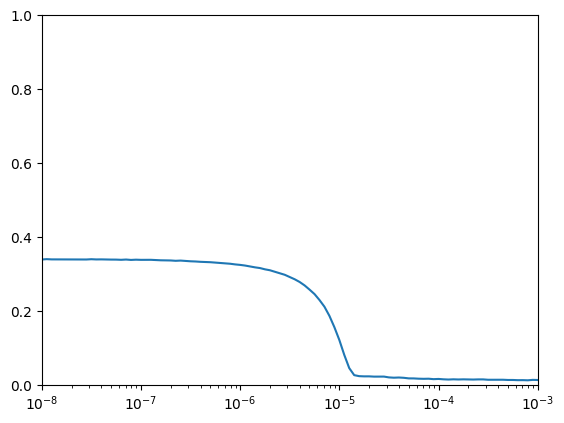

In [28]:
lrs = 1e-8 * (10**(np.arange(200)/20))
plt.semilogx(lrs, history_6.history['loss'])
plt.axis([1e-8, 1e-3,0, 1])

In [29]:
lrs = 1e-8 * (10**(np.arange(200)/20))

In [30]:
lrs

array([1.00000000e-08, 1.12201845e-08, 1.25892541e-08, 1.41253754e-08,
       1.58489319e-08, 1.77827941e-08, 1.99526231e-08, 2.23872114e-08,
       2.51188643e-08, 2.81838293e-08, 3.16227766e-08, 3.54813389e-08,
       3.98107171e-08, 4.46683592e-08, 5.01187234e-08, 5.62341325e-08,
       6.30957344e-08, 7.07945784e-08, 7.94328235e-08, 8.91250938e-08,
       1.00000000e-07, 1.12201845e-07, 1.25892541e-07, 1.41253754e-07,
       1.58489319e-07, 1.77827941e-07, 1.99526231e-07, 2.23872114e-07,
       2.51188643e-07, 2.81838293e-07, 3.16227766e-07, 3.54813389e-07,
       3.98107171e-07, 4.46683592e-07, 5.01187234e-07, 5.62341325e-07,
       6.30957344e-07, 7.07945784e-07, 7.94328235e-07, 8.91250938e-07,
       1.00000000e-06, 1.12201845e-06, 1.25892541e-06, 1.41253754e-06,
       1.58489319e-06, 1.77827941e-06, 1.99526231e-06, 2.23872114e-06,
       2.51188643e-06, 2.81838293e-06, 3.16227766e-06, 3.54813389e-06,
       3.98107171e-06, 4.46683592e-06, 5.01187234e-06, 5.62341325e-06,
      

In [31]:
# lr = 4e-4

In [106]:
import tensorflow as tf
from tensorflow.keras import layers
tf.random.set_seed(42)

model_6 = tf.keras.Sequential()
model_6.add(layers.LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
# model_6.add(layers.Dropout(0.2))
model_6.add(layers.LSTM(128))
model_6.add(layers.Dense(256, activation='relu'))
model_6.add(layers.Dropout(0.2))
model_6.add(layers.Dense(128, activation='relu'))
model_6.add(layers.Dense(128, activation='relu'))
model_6.add(layers.Dropout(0.2))
model_6.add(layers.Dense(128, activation='relu'))
# model_6.add(layers.Dense(128, activation='relu'))
model_6.add(layers.Dense(128, activation='relu'))
model_6.add(layers.Dropout(0.2))
model_6.add(layers.Dense(128, activation='relu'))
model_6.add(layers.Dropout(0.2))
model_6.add(layers.Dense(1, activation='linear'))

model_6.compile(loss = 'MeanSquaredError',
                metrics=['MAE'],
                optimizer=tf.keras.optimizers.Adam(4e-4))
model_6.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 4, 200)            163200    
                                                                 
 lstm_15 (LSTM)              (None, 128)               168448    
                                                                 
 dense_45 (Dense)            (None, 256)               33024     
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_46 (Dense)            (None, 128)               32896     
                                                                 
 dense_47 (Dense)            (None, 128)               16512     
                                                                 
 dropout_21 (Dropout)        (None, 128)              

In [107]:
history_6 = model_6.fit(X_train,
            y_train,
            batch_size=32,
            epochs=70,
            verbose=1,
            validation_split=0.2,
            callbacks=[create_model_checkpoint(model_name="model_6")
                      #  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
                      ])

Epoch 1/70
23/23 [==============================] - 14s 375ms/step - loss: 0.1228 - MAE: 0.2868 - val_loss: 0.0795 - val_MAE: 0.2457
Epoch 2/70
23/23 [==============================] - 7s 318ms/step - loss: 0.0254 - MAE: 0.1311 - val_loss: 0.0550 - val_MAE: 0.1996
Epoch 3/70
23/23 [==============================] - 7s 329ms/step - loss: 0.0222 - MAE: 0.1210 - val_loss: 0.0298 - val_MAE: 0.1413
Epoch 4/70
23/23 [==============================] - 7s 322ms/step - loss: 0.0193 - MAE: 0.1098 - val_loss: 0.0239 - val_MAE: 0.1276
Epoch 5/70
23/23 [==============================] - 0s 9ms/step - loss: 0.0169 - MAE: 0.1017 - val_loss: 0.0391 - val_MAE: 0.1727
Epoch 6/70
23/23 [==============================] - 8s 366ms/step - loss: 0.0170 - MAE: 0.1038 - val_loss: 0.0199 - val_MAE: 0.1138
Epoch 7/70
23/23 [==============================] - 0s 12ms/step - loss: 0.0147 - MAE: 0.0957 - val_loss: 0.0410 - val_MAE: 0.1781
Epoch 8/70
23/23 [==============================] - 0s 9ms/step - loss: 0.0151

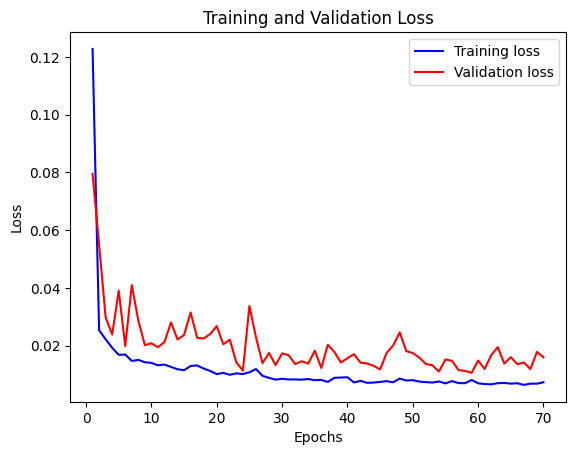

In [108]:
plot_hist_curve(history_6)

In [109]:
# loading best performing model
model_6 = tf.keras.models.load_model("/content/model_collection/model_6")
model_6.evaluate(X_val, y_val)

5/5 [==============================] - 1s 5ms/step - loss: 0.0096 - MAE: 0.0696


[0.00958431325852871, 0.06964070349931717]

In [110]:
pred = model_6.predict(X_val)
# pred = tf.squeeze(pred)
pred.shape

5/5 [==============================] - 1s 3ms/step


(160, 1)

In [111]:
d = {
    'Predicted': pred[:, 0],
    'Actual': y_val[:]
}

d = pd.DataFrame(d)
d.head()

,Predicted,Actual
0,0.663875,0.557864
1,0.578129,0.603515
2,0.616573,0.572929
3,0.582818,0.460169
4,0.501290,0.542342


In [112]:
d[['Predicted']] = output_scalar.inverse_transform(d[['Predicted']])
d[['Actual']] = output_scalar.inverse_transform(d[['Actual']])


d.head()

,Predicted,Actual
0,8151.836914,7905.148368
1,7952.306641,8011.379822
2,8041.765625,7940.204748
3,7963.217285,7677.813056
4,7773.501465,7869.029674


<Axes: >

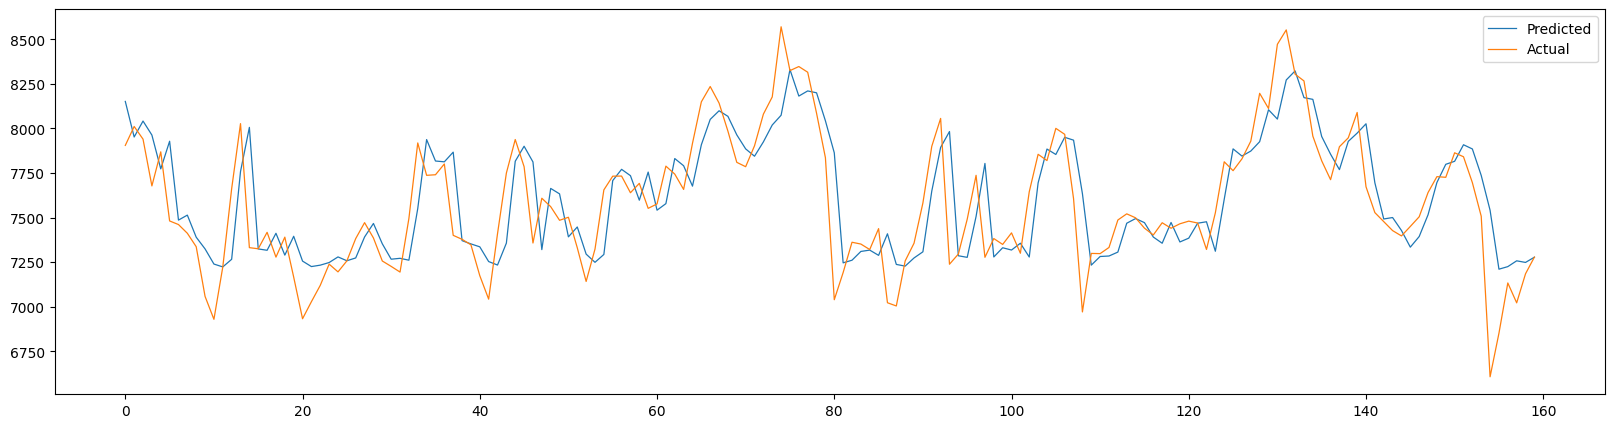

In [113]:
d.plot(figsize=(20, 5), linewidth=0.9)

In [114]:
model_6_eval = evaluate_preds(d['Actual'], d['Predicted'])
model_6_eval

{'mae': 162.05392,
 'mse': 51898.383,
 'rmse': 227.81216,
 'mape': 2.159353,
 'mase': 0.9710985}

###**This hypertuned model_6 is beating all the previous 5 models in terms of MAE and RMSE by reducing to almost half which is till now best among the all**

___

##test on test data

In [115]:
test_df.head()

,energydemand,min temparature,max temparature
Date,,,
2020-12-02,7123,19.73,29.54
2020-12-03,7124,20.81,29.65
2020-12-04,7218,21.38,28.54
2020-12-05,7115,21.39,30.07
2020-12-06,6819,20.99,30.16


In [116]:
test_df.shape

(30, 3)

In [117]:
prev_observ = train_df.tail(4)

new_test_df = pd.concat(objs=[prev_observ, test_df])
new_test_df.shape


(34, 3)

In [118]:
new_test_df.head()

,energydemand,min temparature,max temparature
Date,,,
2020-11-28,6817,19.98,23.92
2020-11-29,6607,21.75,26.98
2020-11-30,6914,20.77,28.53
2020-12-01,7090,19.94,30.21
2020-12-02,7123,19.73,29.54


In [119]:
new_test_df = new_test_df.sort_index()

In [120]:
test_scaled_df = scalar.fit_transform(new_test_df.to_numpy())
test_scaled_df = pd.DataFrame(test_scaled_df, columns = list(test_df.columns))

In [121]:
test_scaled_df[["energydemand"]] = output_scalar.fit_transform(new_test_df[['energydemand']].to_numpy())

In [122]:
sequence, labels = window_maker(test_scaled_df, 4)

In [123]:
sequence.shape, labels.shape

((30, 4, 3), (30,))

In [124]:
test_pred = model_6.predict(sequence)

1/1 [==============================] - 1s 663ms/step


In [125]:
d = {
    'Predicted': test_pred[:, 0],
    'Actual': labels[:]
}

test_d = pd.DataFrame(d)
test_d.head()

,Predicted,Actual
0,0.292371,0.221745
1,0.289683,0.222174
2,0.283517,0.262570
3,0.284147,0.218307
4,0.281809,0.091104


In [126]:
test_d.index = test_df.index

In [127]:
test_d[['Predicted']] = output_scalar.inverse_transform(test_d[['Predicted']])
test_d[['Actual']] = output_scalar.inverse_transform(test_d[['Actual']])


test_d.head()

,Predicted,Actual
Date,,
2020-12-02,7287.346680,7123.0
2020-12-03,7281.092285,7124.0
2020-12-04,7266.743164,7218.0
2020-12-05,7268.210449,7115.0
2020-12-06,7262.768555,6819.0


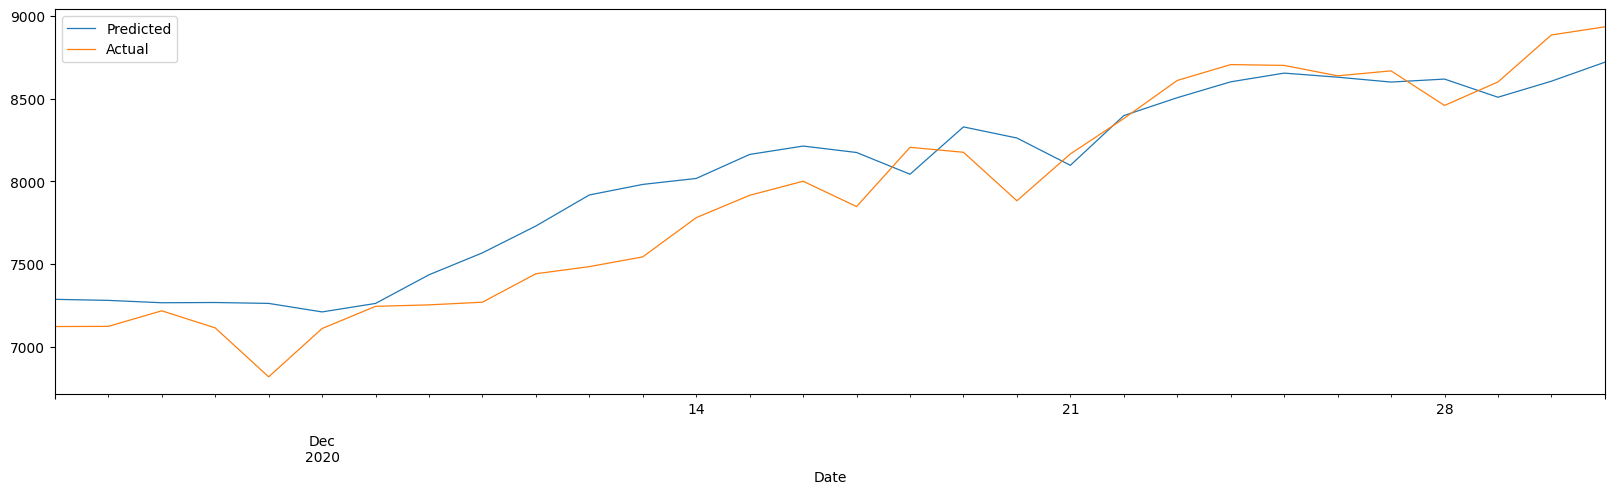

In [128]:
test_d.plot(figsize=(20, 5), linewidth=0.9);

In [129]:
test_eval_res2 = evaluate_preds(test_d['Actual'], test_d['Predicted'])
test_eval_res2

{'mae': 186.83688,
 'mse': 50779.957,
 'rmse': 225.34409,
 'mape': 2.4198792,
 'mase': 1.316712}

In [130]:
test_d

,Predicted,Actual
Date,,
2020-12-02,7287.346680,7123.0
2020-12-03,7281.092285,7124.0
2020-12-04,7266.743164,7218.0
2020-12-05,7268.210449,7115.0
2020-12-06,7262.768555,6819.0
2020-12-07,7211.311523,7111.0
2020-12-08,7262.626953,7245.0
2020-12-09,7435.692871,7254.0
2020-12-10,7568.244141,7270.0


**Above is the actual vs predicted forecasting for unseen 30 days data based on given temparature trend with mae is 186**